# Calculate Labor Productivity Change Due to Heat Stress
**By: Iman haqiqi, Department of Agricultural Economics, Purdue University**

First version: October 4, 2024

Contact: ihaqiqi@purdue.edu

**How to cite:**

This code is slightly modified version of the codes used for: Saeed, W., I. Haqiqi, Q. Kong, M. Huber, J. R. Buzan, S. Chonabayashi, K. Motohashi, and T. W. Hertel. "The poverty impacts of labor heat stress in West Africa under a warming climate." Earth's Future 10, no. 11 (2022).  https://doi.org/10.1029/2022EF002777


## 1. Objective
This code takes the WBGT estimates based on climate projections and convert it to labor productivity change for use in economic models.

### 1.1. File structure
The inputs are WBGT estimates with the following details:

- warming scenario 1C, 2C, 3C, 4C, 5C
- climate models: 
  * "ACCESS_CM2",
  * "CMCC-CM2-SR5",  
  * "EC-Earth3_r1i1p1f1",     
  * "EC-Earth3_r3i1p1f1",    
  * "EC-Earth3_r4i1p1f1",     
  * "HadGEM3-GC31-LL",       
  * "HadGEM3-GC31-MM", 
  * "BCC-CSM2-MR", 
  * "MPI-ESM1-2-HR_r1i1p1f1", 
  * "MPI-ESM1-2-HR_r2i1p1f1",  
  * "MPI-ESM1-2-LR", 
  * "MRI-ESM2-0", 
  * "MIROC6", 
  * "KIOST-ESM" 
- indoor vs outdoor
- daytime vs allday
- work intensity: w200, w300, w400, w600

The outputs are labor productivity change for farmworkers in the agricultural sector by
- climate model and
- warming scenario


# 2. R scripts to compute the shocks
The WBGT is calculated at the global level. Here we provide an example for the US.

## 2.1. Required R packages
This code requires "terra" and "ncdf4".

In [36]:
# libraries
library(terra)
library(ncdf4)


## 2.2. Introducing components of each set
For the main paper we considered multiple climate models and warming scenarios. This section introduces the elements of each set.

In [37]:
# gcm models
gcm.list = c("ACCESS_CM2",           
          "CMCC-CM2-SR5",           
          "EC-Earth3_r1i1p1f1",     
          "EC-Earth3_r3i1p1f1",    
          "EC-Earth3_r4i1p1f1",     
          "HadGEM3-GC31-LL",       
          "HadGEM3-GC31-MM",
          "BCC-CSM2-MR",
          "MPI-ESM1-2-HR_r1i1p1f1",
          "MPI-ESM1-2-HR_r2i1p1f1", 
          "MPI-ESM1-2-LR",         
          "MRI-ESM2-0",
          "MIROC6", 
          "KIOST-ESM")   

# labor categories
  labor.list = c("Labor_unskilled",	"Labor_office",	"Labor_techpro",	"Labor_services")

# economic activities
  activity.list = c("Agriculture",	"Extraction",	"Construction",	"Manufacturing",	"Trade",	"Transportation",	"Services")

# global warming levels
  warming.list = c("1C" , "2C", "3C", "4C", "5C")


## 2.3. Read parameters
To calculate the productivity shock by economic sectors, we need to know the share of each working intesnity and exposure to sun.

In [38]:
# ---- read the required data files ----

# work intensity by labor category and economic activity
  work.rate = read.csv("data/US_workingRate_v2.csv", sep=",", header = T)

# exposure to outdoor sun as the share of working day
  outdoor.time = read.csv("data/US_outdoorLabor_v3.csv", sep=",", header = T)


## 2.4. Example computation 
This example illustrates the computation process for MIROC6, 3C, unskilled labor, in agriculture.

In [39]:
g = gcm.list[13]
w = warming.list[3]
l = labor.list[1]
a = activity.list[1]
        
print(paste(g, w, l , a, sep=" - "))

[1] "MIROC6 - 3C - Labor_unskilled - Agriculture"


### 2.4.1. Read data and compute loss
Depending on the specific parameters, the final impact on labor productivity is calculated. 

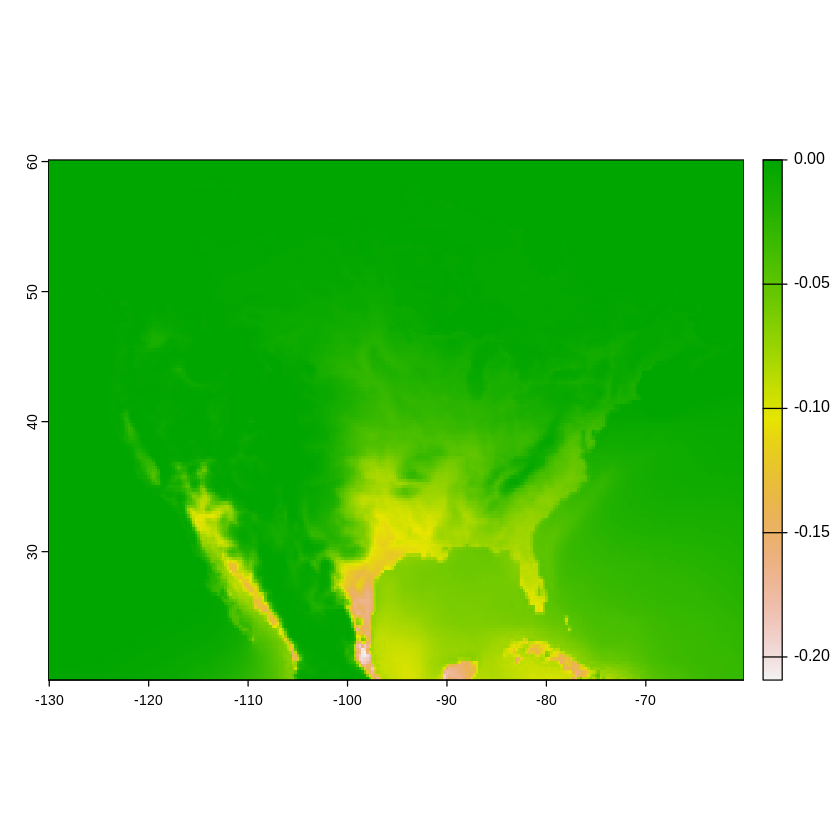

In [17]:
          
          shr_200w = subset(work.rate, labor == l & work_rate == "w200" & activity == a)$Value
          shr_300w = subset(work.rate, labor == l & work_rate == "w300" & activity == a)$Value
          shr_400w = subset(work.rate, labor == l & work_rate == "w400" & activity == a)$Value
          shr_600w = subset(work.rate, labor == l & work_rate == "w600" & activity == a)$Value
          
          loss_200w_ind  = rast(paste0("WBGT_US/", g, "/indoor_daytime/200w_",w,".nc"))
          loss_300w_ind  = rast(paste0("WBGT_US/", g, "/indoor_daytime/300w_",w,".nc"))
          loss_400w_ind  = rast(paste0("WBGT_US/", g, "/indoor_daytime/400w_",w,".nc"))
          loss_600w_ind  = rast(paste0("WBGT_US/", g, "/indoor_daytime/600w_",w,".nc"))
          
          loss_200w_out  = rast(paste0("WBGT_US/", g, "/outdoor_daytime/200w_",w,".nc"))
          loss_300w_out  = rast(paste0("WBGT_US/", g, "/outdoor_daytime/300w_",w,".nc"))
          loss_400w_out  = rast(paste0("WBGT_US/", g, "/outdoor_daytime/400w_",w,".nc"))
          loss_600w_out  = rast(paste0("WBGT_US/", g, "/outdoor_daytime/600w_",w,".nc"))          
          
          shr_outdoor = subset(outdoor.time, labor == l &  activity == a)$Value          
        
          outdoor_loss = (shr_200w*loss_200w_out + shr_300w*loss_300w_out + shr_400w*loss_400w_out + shr_600w*loss_600w_out);
          indoor_loss  = (shr_200w*loss_200w_ind + shr_300w*loss_300w_ind + shr_400w*loss_400w_ind + shr_600w*loss_600w_ind) ;
          
          loss = shr_outdoor  * outdoor_loss + (1-shr_outdoor) * indoor_loss

plot(loss)
          
 

### 2.4.2 Reading SIMPLE-G grid IDs
SIMPLE-G assigns specific IDs to each grid cell. The shocks should be matched to the IDs according to the coordinates of the grid cells. 

In [41]:

# this is the map of grid IDs of the SIMPLE-G-US model
simpleg.gid.file = "data/SIMPLEG_GRID_5min.tif"

# use the rast() function to read the tif file as a raster
grid_5min  <- rast(simpleg.gid.file)

# define a map of grid cells available in SIMPLE-G model
is.simpleg <- grid_5min/grid_5min

# report the number of grid cells in the continental US: 75,651
global(is.simpleg, sum, na.rm=T)



,sum
,<dbl>
GID,75651


### 2.4.3. Convert the rasters to CSV
Convert the rasters to dataframe and save as CSV.


In [42]:
    
output.file.csv  = paste("AgLabor_csv/Labor", w, g, "CMIP6.csv", sep="_")

# an scalar to convert the shocks to % change for use in SIMPLE-G
scale.shock  = 100
      # read the labor productivity shock file
      shock <- project(loss, crs(grid_5min))
    
      # crop to the SIMPLE-G model spatial extent
      shock.crp  <- crop(shock, grid_5min)
      
      # write US netcdf
      writeCDF(shock.crp, paste0("AgLabor_US/", g ,"/Labor_unskilled_Agriculture_", w , ".nc"),  overwrite=TRUE)
      
      # convert to % for use in SIMPLE-G
      shock.scl <- shock.crp * scale.shock
      
      # resample to ensure consistency
      shock.prj  <- resample(shock.scl, grid_5min)
      
      # assign 0% if NA
      shock.prj [is.na(shock.prj )] <- 0
      
      # remove the the grid cells out of SIMPLE-G
      shock.final <- shock.prj *is.simpleg
      
      # convert to data frame
      df <- as.data.frame(c(grid_5min, shock.final), xy=T)
      df <-df[order(df$GID),]
      
      # Write CSV 
      write.csv(df, file = output.file.csv, row.names = F)


# 3. Visualization
Plot the results with different coordinate reference systems. 

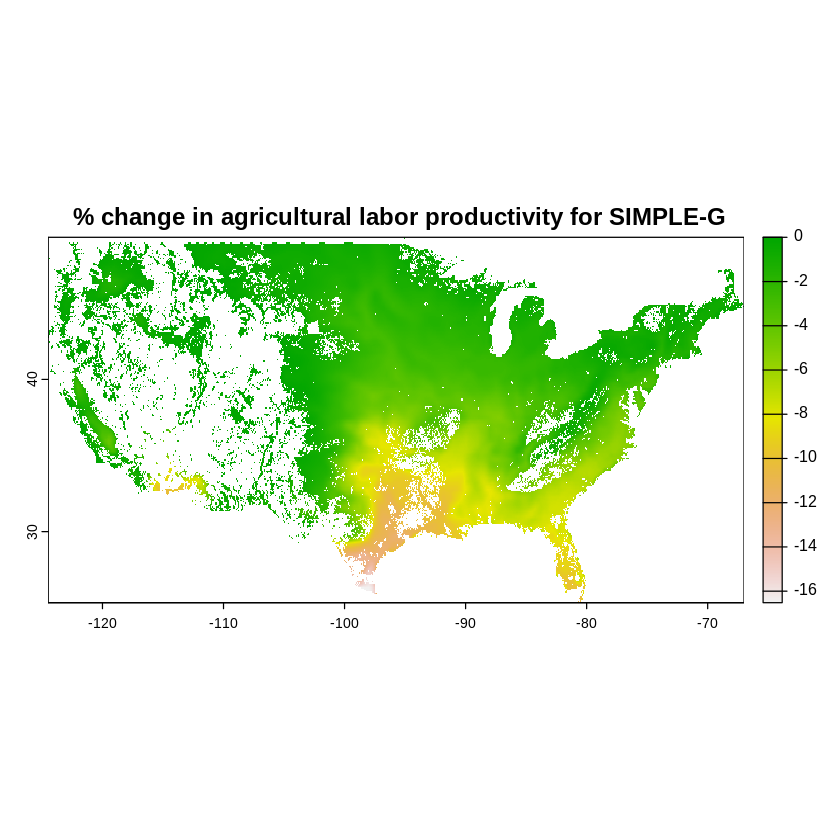

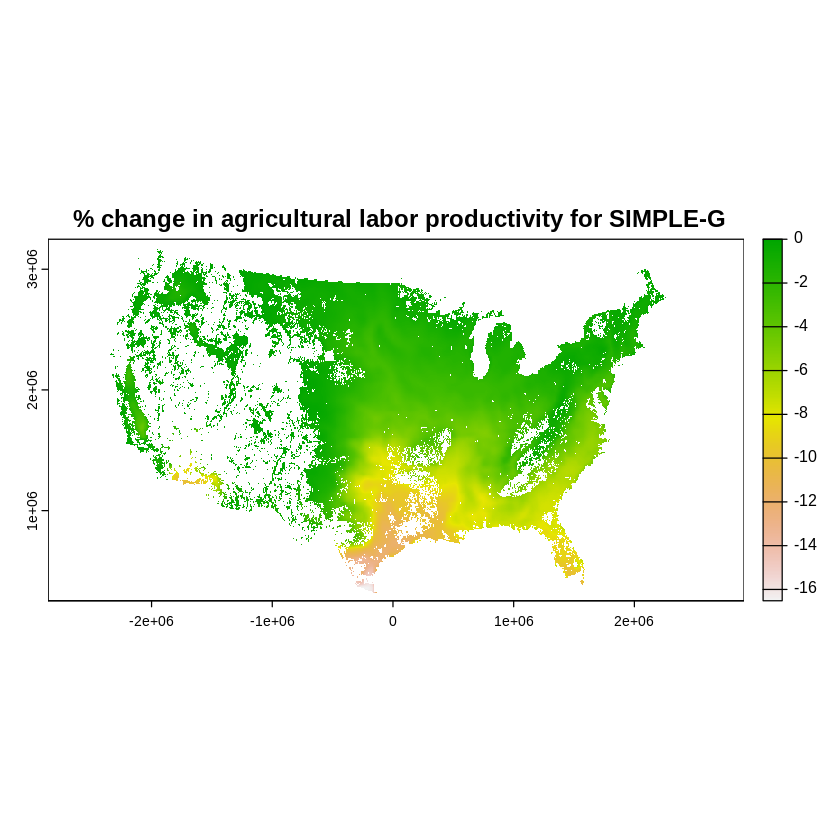

In [43]:

     # crs for plots
      wgs_crs <- "epsg:4326"
      aea_crs <- "EPSG:5070"
    

      # plot the result
      plot(shock.final, main=" % change in agricultural labor productivity for SIMPLE-G")


      # Define the target CRS for Albers Equal Area (EPSG: 5070)
      shock.aea <- project(shock.final, aea_crs)

      # plot the result
      plot(shock.aea, main=" % change in agricultural labor productivity for SIMPLE-G")        

      


# 4. Conclusion
This code illustrated the calculation of labor productivity shock for use in the SIMPLE-G-US model.